In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rc_tools as rct
import rc_matrices as rcm
import rc_analysis as rca
import sys
import time

from sklearn.metrics import mean_squared_error
from scipy.signal import argrelmax
from scipy.special import kl_div
from scipy.optimize import fsolve
import pdb
import warnings
warnings.filterwarnings("ignore")
np.random.seed(11)
import scipy
import nolds
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec

import seaborn as sns
import pandas as pd

In [2]:
fontsize = 24
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["text.usetex"] = True 
plt.rcParams["axes.xmargin"] = 0 
plt.rcParams["axes.titlesize"] = 26 
plt.rcParams["axes.labelsize"] = 26 
plt.rcParams["xtick.labelsize"] = fontsize 
plt.rcParams["ytick.labelsize"] = fontsize
plt.rcParams["xtick.color"] = 'black'
plt.rcParams["ytick.color"] = 'black'
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}"  #lmodern

In [3]:
def rank_along_trajectory(wr, wi, a, g, forcing, n, k, tolerance, delX):
    T = forcing.shape[0]
    ranks = np.zeros(T)
    conds = np.zeros(T)
    radii = np.zeros(T)
    uncertainty = np.zeros((n,T))
    def Func(x):
        return np.squeeze(-x.reshape(n,1) + (1-a)*x.reshape(n,1) +\
                          a*g*np.tanh(np.dot(wr,x.reshape(n,1)) +\
                         (np.dot(wi,ueq.reshape(k,1)).reshape(n,1))))
    for i in range(T):
        ueq = forcing[i]
        x0 = np.ones((n,1))*.5
        xeq = (fsolve(Func,x0)).reshape(n,1)
        A = rca.leaky_jacobian(xeq, ueq.reshape(k,1), a, g, Wi, Wr)
        radii[i] = np.max(np.abs(rca.eig_spectrum(A)))
        conds[i] = rca.condition_number(A)[0]
        B = rca.partial_u(xeq, ueq.reshape(k,1), a, g, Wi, Wr)
        uncertainty[:,i] = np.squeeze(np.dot(A,delX))
        Cplus = rca.controllability_matrix(A, B)
        ranks[i] = rca.rank(Cplus, tolerance)
        print(f'Time-step: {i} Rank: {ranks[i]} Uncertainty: {np.linalg.norm(uncertainty):.2f}  CondNum: {conds[i]:.2f}')
    return ranks, uncertainty, conds, radii

def NRMSE(target, pred,std):
    rmse = np.sqrt(mean_squared_error(target, pred))
    return rmse/std

def support(target, pred):
    mn = np.max([np.min(target),np.min(pred)])
    mx = np.min([np.max(target),np.max(pred)])
    return mn, mx

tols = [1/10**(x) for x in range(0,30)]

In [4]:
signal = np.load('Lxyz_signal.npy')

In [7]:
maxmin = np.max(signal[:15000],axis=0)-np.min(signal[:15000],axis=0)

In [8]:
N = 25
K = 3
it = 363
top,bottom  = 13900,15000
mu = np.array([.56018255, .55704211, 23.59124571])

#'models_8_1/L3D_ctr{it}_{N}_instanceParams.npy'
iterParams = np.load(f'L3D25/L3D_ctr103_25_instanceParams.npy', allow_pickle=True)
print(f'Iter parameters: {iterParams}')
ALPHA = iterParams[0]
GAMMA = iterParams[2]
stdz = np.std(signal[:15000], axis=0)
print(f'Std. Dev.{stdz}')
print(f'Mean {mu}')
yhat = np.load(f'L3D25/L3D_ctr103_25_preds.npy', allow_pickle=True)
NRMSE = np.sqrt(mean_squared_error(signal[14000:15000],yhat[14000:15000], multioutput='raw_values'))/maxmin
print(f'NRMSE = {NRMSE}')
Wr, Wi = rca.get_mats(f'L3D25/L3D_ctr103_25_Wnet.npy', 3, N)
posInf, negInf = rca.gains(Wi)
print(f'Positive Inf Norm {posInf}    Negative Inf Norm {negInf}')
xeq = np.zeros((N,1))
ueq = np.zeros((K,1))
A = rca.leaky_jacobian(xeq, ueq, ALPHA, GAMMA, Wi, Wr)
B = rca.partial_u(xeq, ueq, ALPHA, GAMMA, Wi, Wr)
Cplus = rca.controllability_matrix(A, B)
svs = np.linalg.svd(Cplus, compute_uv=False)
Cplus = Cplus/np.max(svs)
rank_tols = []
for i in tols:
    rank_tols.append(rca.rank(Cplus, i))

Iter parameters: [0.6778943951788552 0.6707643428723213 3.7859721331943588
 0.06013247289499634 2.316718589896131 76.30440381993587
 0.05157127751549946 array([0.93562896]) array([0.97135024])
 array([0.91463838])]
Std. Dev.[7.9122292  8.99288317 8.56681415]
Mean [ 0.56018255  0.55704211 23.59124571]
NRMSE = [0.19454193 0.1662768  0.16716779]
Positive Inf Norm 0.07547839730978012    Negative Inf Norm 0.02654009871184826


In [10]:
yhat300 = np.load(f'L3D300/L3D_ctr183_300_preds.npy', allow_pickle=True)
NRMSE300 = np.sqrt(mean_squared_error(signal[14000:15000],yhat[14000:15000], multioutput='raw_values'))/maxmin
NRMSE300

array([0.19454193, 0.1662768 , 0.16716779])

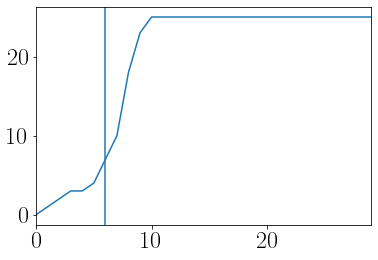

Tolerance 1e-06	 Rank 7
Tolerance 1e-07	 Rank 10
Ave rank on segment 8.5


In [7]:
v=6


plt.plot(rank_tols)
plt.axvline(v)

plt.show()
plt.close()
# Should it calculate xbar?

print(f'Tolerance {tols[v]}\t Rank {rank_tols[v]}')
print(f'Tolerance {tols[v+1]}\t Rank {rank_tols[v+1]}')
print(f'Ave rank on segment {(rank_tols[v]+rank_tols[v+1])/2}')
# Should it calculate xbar?

In [8]:
bn_list = [50,50,50]
bds = [(-19,19),(-24,24),(-21,21)]
for i in range(3):
    mn, mx = support(signal[14000:,i], yhat[14000:,i])
    #print(f'mn {mn}   mx {mx}')
    #print(f'bds {bds[i][0]} {bds[i][1]}')
    kl = rca.distribution(signal[14000:,i],yhat[14000:,i],bds[i][0],bds[i][1], bn_list[i])
    #print(kl[1]*np.log(kl[1]/kl[2]))
    print(f'Var {i}  KL {kl[0]}')

Var 0  KL 0.15906338523342986
Var 1  KL 0.06118033670082525
Var 2  KL 0.06693056681966764


In [9]:
np.gradient(rank_tols)

array([1. , 1. , 1. , 0.5, 0.5, 2. , 3. , 5.5, 6.5, 3.5, 1. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. ])

In [10]:
bn_list = [50,50,50]
bds = [(-19,19),(-27,27),(-25,25)]
for i in range(3):
    mn, mx = support(signal[14000:,i], yhat[14000:,i])
    print(f'mn {mn}   mx {mx}')
    #print(f'bds {bds[i][0]} {bds[i][1]}')
    kl = rca.distribution(signal[14000:,i],yhat[14000:,i],bds[i][0],bds[i][1], bn_list[i])
    #print(kl[1]*np.log(kl[1]/kl[2]))
    print(f'Var {i}  KL {kl[0]}')

mn -18.08428382873535   mx 16.661383243009862
Var 0  KL 0.15906338523342986
mn -23.690095901489258   mx 22.18527026383207
Var 1  KL 0.003149819304543722
mn -17.236481495331883   mx 20.65044593811035
Var 2  KL 0.06464828973604117


In [11]:
start, end = 14000,16000
uVecs = np.zeros((N,2000))
for i in range(start,end):
    uVecs[:,i-14000] = Wi[:,0]*signal[i,2]

diffs = np.diff(uVecs, axis=1)
norms = np.zeros(2000)
for i in range(diffs.shape[1]):
    norms[i] = np.linalg.norm(diffs[:,i])
np.argmax(norms)

maxX = diffs[:,772][:,np.newaxis]

In [12]:
K=3
tval = v
start, end= 13900,15000
preds = yhat#np.load(f'Consistent/L3D/L3D{N}/L3D_iter{it}_{N}_preds.npy') 
#Wr, Wi = rca.get_mats(f'Consistent/L3D/L3D{N}/L3D_iter{it}_{N}_Wnet.npy',K,N)
p = iterParams#np.load(f'Consistent/L3D/L3D{N}/L3D_iter{it}_{N}_instanceParams.npy')
sig_rks30, uncSig, cNum, sigradius  = rank_along_trajectory( Wr, Wi, p[0], p[2],
                            signal[start:end],N, K, tols[tval], maxX)
pred_rks30, uncSig, cNum, prdradius  = rank_along_trajectory( Wr, Wi, p[0], p[2],
                            yhat[start:end],N, K, tols[tval], maxX)

Time-step: 0 Rank: 25.0 Uncertainty: 0.21  CondNum: 198.77
Time-step: 1 Rank: 25.0 Uncertainty: 0.29  CondNum: 188.83
Time-step: 2 Rank: 25.0 Uncertainty: 0.36  CondNum: 179.85
Time-step: 3 Rank: 25.0 Uncertainty: 0.41  CondNum: 168.14
Time-step: 4 Rank: 25.0 Uncertainty: 0.46  CondNum: 183.94
Time-step: 5 Rank: 25.0 Uncertainty: 0.50  CondNum: 184.85
Time-step: 6 Rank: 25.0 Uncertainty: 0.54  CondNum: 187.27
Time-step: 7 Rank: 25.0 Uncertainty: 0.58  CondNum: 191.36
Time-step: 8 Rank: 25.0 Uncertainty: 0.61  CondNum: 188.01
Time-step: 9 Rank: 25.0 Uncertainty: 0.64  CondNum: 201.41
Time-step: 10 Rank: 25.0 Uncertainty: 0.65  CondNum: 344.59
Time-step: 11 Rank: 25.0 Uncertainty: 0.67  CondNum: 267.81
Time-step: 12 Rank: 25.0 Uncertainty: 0.70  CondNum: 182.15
Time-step: 13 Rank: 25.0 Uncertainty: 0.71  CondNum: 195.72
Time-step: 14 Rank: 25.0 Uncertainty: 0.72  CondNum: 166.79
Time-step: 15 Rank: 25.0 Uncertainty: 0.73  CondNum: 173.72
Time-step: 16 Rank: 25.0 Uncertainty: 0.74  CondNu

Time-step: 156 Rank: 25.0 Uncertainty: 2.29  CondNum: 182.89
Time-step: 157 Rank: 25.0 Uncertainty: 2.30  CondNum: 192.42
Time-step: 158 Rank: 25.0 Uncertainty: 2.31  CondNum: 187.09
Time-step: 159 Rank: 25.0 Uncertainty: 2.31  CondNum: 367.13
Time-step: 160 Rank: 25.0 Uncertainty: 2.31  CondNum: 299.27
Time-step: 161 Rank: 25.0 Uncertainty: 2.32  CondNum: 182.20
Time-step: 162 Rank: 25.0 Uncertainty: 2.33  CondNum: 227.72
Time-step: 163 Rank: 25.0 Uncertainty: 2.34  CondNum: 181.86
Time-step: 164 Rank: 25.0 Uncertainty: 2.34  CondNum: 161.71
Time-step: 165 Rank: 25.0 Uncertainty: 2.34  CondNum: 169.53
Time-step: 166 Rank: 25.0 Uncertainty: 2.35  CondNum: 162.47
Time-step: 167 Rank: 25.0 Uncertainty: 2.35  CondNum: 164.37
Time-step: 168 Rank: 25.0 Uncertainty: 2.36  CondNum: 168.92
Time-step: 169 Rank: 25.0 Uncertainty: 2.36  CondNum: 169.64
Time-step: 170 Rank: 25.0 Uncertainty: 2.37  CondNum: 163.43
Time-step: 171 Rank: 25.0 Uncertainty: 2.38  CondNum: 158.99
Time-step: 172 Rank: 25.

Time-step: 313 Rank: 25.0 Uncertainty: 3.20  CondNum: 215.85
Time-step: 314 Rank: 25.0 Uncertainty: 3.21  CondNum: 220.08
Time-step: 315 Rank: 25.0 Uncertainty: 3.21  CondNum: 222.48
Time-step: 316 Rank: 25.0 Uncertainty: 3.22  CondNum: 227.53
Time-step: 317 Rank: 25.0 Uncertainty: 3.22  CondNum: 222.75
Time-step: 318 Rank: 25.0 Uncertainty: 3.23  CondNum: 257.99
Time-step: 319 Rank: 25.0 Uncertainty: 3.23  CondNum: 682.81
Time-step: 320 Rank: 25.0 Uncertainty: 3.24  CondNum: 458.49
Time-step: 321 Rank: 25.0 Uncertainty: 3.24  CondNum: 213.63
Time-step: 322 Rank: 25.0 Uncertainty: 3.24  CondNum: 275.93
Time-step: 323 Rank: 25.0 Uncertainty: 3.25  CondNum: 230.39
Time-step: 324 Rank: 25.0 Uncertainty: 3.25  CondNum: 181.14
Time-step: 325 Rank: 25.0 Uncertainty: 3.25  CondNum: 188.82
Time-step: 326 Rank: 25.0 Uncertainty: 3.25  CondNum: 198.11
Time-step: 327 Rank: 25.0 Uncertainty: 3.26  CondNum: 197.54
Time-step: 328 Rank: 25.0 Uncertainty: 3.26  CondNum: 243.12
Time-step: 329 Rank: 25.

Time-step: 458 Rank: 25.0 Uncertainty: 3.82  CondNum: 174.35
Time-step: 459 Rank: 25.0 Uncertainty: 3.82  CondNum: 167.94
Time-step: 460 Rank: 25.0 Uncertainty: 3.83  CondNum: 161.10
Time-step: 461 Rank: 25.0 Uncertainty: 3.83  CondNum: 196.61
Time-step: 462 Rank: 25.0 Uncertainty: 3.84  CondNum: 198.69
Time-step: 463 Rank: 25.0 Uncertainty: 3.84  CondNum: 200.42
Time-step: 464 Rank: 25.0 Uncertainty: 3.85  CondNum: 199.92
Time-step: 465 Rank: 25.0 Uncertainty: 3.85  CondNum: 197.77
Time-step: 466 Rank: 25.0 Uncertainty: 3.86  CondNum: 220.83
Time-step: 467 Rank: 25.0 Uncertainty: 3.86  CondNum: 448.42
Time-step: 468 Rank: 25.0 Uncertainty: 3.86  CondNum: 333.95
Time-step: 469 Rank: 25.0 Uncertainty: 3.87  CondNum: 185.78
Time-step: 470 Rank: 25.0 Uncertainty: 3.87  CondNum: 225.05
Time-step: 471 Rank: 25.0 Uncertainty: 3.87  CondNum: 179.92
Time-step: 472 Rank: 25.0 Uncertainty: 3.87  CondNum: 167.27
Time-step: 473 Rank: 25.0 Uncertainty: 3.88  CondNum: 167.12
Time-step: 474 Rank: 25.

Time-step: 616 Rank: 25.0 Uncertainty: 4.42  CondNum: 193.40
Time-step: 617 Rank: 25.0 Uncertainty: 4.42  CondNum: 188.00
Time-step: 618 Rank: 25.0 Uncertainty: 4.42  CondNum: 199.71
Time-step: 619 Rank: 25.0 Uncertainty: 4.43  CondNum: 160.80
Time-step: 620 Rank: 25.0 Uncertainty: 4.43  CondNum: 163.36
Time-step: 621 Rank: 25.0 Uncertainty: 4.43  CondNum: 168.49
Time-step: 622 Rank: 25.0 Uncertainty: 4.44  CondNum: 164.07
Time-step: 623 Rank: 25.0 Uncertainty: 4.44  CondNum: 160.32
Time-step: 624 Rank: 25.0 Uncertainty: 4.44  CondNum: 163.17
Time-step: 625 Rank: 25.0 Uncertainty: 4.44  CondNum: 175.37
Time-step: 626 Rank: 25.0 Uncertainty: 4.44  CondNum: 199.38
Time-step: 627 Rank: 25.0 Uncertainty: 4.45  CondNum: 250.44
Time-step: 628 Rank: 25.0 Uncertainty: 4.45  CondNum: 413.43
Time-step: 629 Rank: 25.0 Uncertainty: 4.45  CondNum: 706.57
Time-step: 630 Rank: 25.0 Uncertainty: 4.45  CondNum: 746.15
Time-step: 631 Rank: 25.0 Uncertainty: 4.45  CondNum: 551.67
Time-step: 632 Rank: 25.

Time-step: 772 Rank: 25.0 Uncertainty: 4.92  CondNum: 168.34
Time-step: 773 Rank: 25.0 Uncertainty: 4.92  CondNum: 162.58
Time-step: 774 Rank: 25.0 Uncertainty: 4.92  CondNum: 159.65
Time-step: 775 Rank: 25.0 Uncertainty: 4.93  CondNum: 165.62
Time-step: 776 Rank: 25.0 Uncertainty: 4.93  CondNum: 183.83
Time-step: 777 Rank: 25.0 Uncertainty: 4.93  CondNum: 234.59
Time-step: 778 Rank: 24.0 Uncertainty: 4.93  CondNum: 344.17
Time-step: 779 Rank: 25.0 Uncertainty: 4.93  CondNum: 723.97
Time-step: 780 Rank: 25.0 Uncertainty: 4.94  CondNum: 1499.01
Time-step: 781 Rank: 25.0 Uncertainty: 4.94  CondNum: 1347.84
Time-step: 782 Rank: 25.0 Uncertainty: 4.94  CondNum: 642.03
Time-step: 783 Rank: 25.0 Uncertainty: 4.94  CondNum: 445.09
Time-step: 784 Rank: 25.0 Uncertainty: 4.94  CondNum: 220.23
Time-step: 785 Rank: 25.0 Uncertainty: 4.95  CondNum: 198.62
Time-step: 786 Rank: 25.0 Uncertainty: 4.95  CondNum: 294.96
Time-step: 787 Rank: 25.0 Uncertainty: 4.95  CondNum: 211.36
Time-step: 788 Rank: 2

Time-step: 926 Rank: 25.0 Uncertainty: 5.38  CondNum: 161.60
Time-step: 927 Rank: 25.0 Uncertainty: 5.38  CondNum: 161.82
Time-step: 928 Rank: 25.0 Uncertainty: 5.38  CondNum: 162.43
Time-step: 929 Rank: 25.0 Uncertainty: 5.39  CondNum: 156.00
Time-step: 930 Rank: 25.0 Uncertainty: 5.39  CondNum: 150.83
Time-step: 931 Rank: 25.0 Uncertainty: 5.39  CondNum: 149.33
Time-step: 932 Rank: 25.0 Uncertainty: 5.39  CondNum: 148.68
Time-step: 933 Rank: 25.0 Uncertainty: 5.40  CondNum: 150.13
Time-step: 934 Rank: 25.0 Uncertainty: 5.40  CondNum: 162.63
Time-step: 935 Rank: 25.0 Uncertainty: 5.40  CondNum: 177.65
Time-step: 936 Rank: 25.0 Uncertainty: 5.41  CondNum: 192.63
Time-step: 937 Rank: 25.0 Uncertainty: 5.41  CondNum: 255.22
Time-step: 938 Rank: 25.0 Uncertainty: 5.41  CondNum: 167.83
Time-step: 939 Rank: 25.0 Uncertainty: 5.42  CondNum: 161.26
Time-step: 940 Rank: 25.0 Uncertainty: 5.42  CondNum: 180.17
Time-step: 941 Rank: 25.0 Uncertainty: 5.42  CondNum: 207.21
Time-step: 942 Rank: 25.

Time-step: 1091 Rank: 25.0 Uncertainty: 5.87  CondNum: 191.66
Time-step: 1092 Rank: 25.0 Uncertainty: 5.87  CondNum: 179.18
Time-step: 1093 Rank: 25.0 Uncertainty: 5.88  CondNum: 169.41
Time-step: 1094 Rank: 25.0 Uncertainty: 5.88  CondNum: 161.29
Time-step: 1095 Rank: 25.0 Uncertainty: 5.88  CondNum: 153.87
Time-step: 1096 Rank: 25.0 Uncertainty: 5.89  CondNum: 153.42
Time-step: 1097 Rank: 25.0 Uncertainty: 5.89  CondNum: 165.68
Time-step: 1098 Rank: 25.0 Uncertainty: 5.89  CondNum: 170.13
Time-step: 1099 Rank: 25.0 Uncertainty: 5.89  CondNum: 171.89
Time-step: 0 Rank: 25.0 Uncertainty: 0.21  CondNum: 188.91
Time-step: 1 Rank: 25.0 Uncertainty: 0.29  CondNum: 179.88
Time-step: 2 Rank: 25.0 Uncertainty: 0.35  CondNum: 167.98
Time-step: 3 Rank: 25.0 Uncertainty: 0.41  CondNum: 182.78
Time-step: 4 Rank: 25.0 Uncertainty: 0.45  CondNum: 184.89
Time-step: 5 Rank: 25.0 Uncertainty: 0.50  CondNum: 186.00
Time-step: 6 Rank: 25.0 Uncertainty: 0.54  CondNum: 187.98
Time-step: 7 Rank: 25.0 Uncer

Time-step: 141 Rank: 25.0 Uncertainty: 2.15  CondNum: 167.12
Time-step: 142 Rank: 25.0 Uncertainty: 2.16  CondNum: 195.50
Time-step: 143 Rank: 25.0 Uncertainty: 2.17  CondNum: 217.66
Time-step: 144 Rank: 25.0 Uncertainty: 2.18  CondNum: 280.31
Time-step: 145 Rank: 25.0 Uncertainty: 2.19  CondNum: 346.83
Time-step: 146 Rank: 25.0 Uncertainty: 2.20  CondNum: 295.11
Time-step: 147 Rank: 25.0 Uncertainty: 2.21  CondNum: 257.02
Time-step: 148 Rank: 25.0 Uncertainty: 2.22  CondNum: 232.69
Time-step: 149 Rank: 25.0 Uncertainty: 2.23  CondNum: 215.20
Time-step: 150 Rank: 25.0 Uncertainty: 2.24  CondNum: 201.21
Time-step: 151 Rank: 25.0 Uncertainty: 2.25  CondNum: 188.18
Time-step: 152 Rank: 25.0 Uncertainty: 2.26  CondNum: 174.20
Time-step: 153 Rank: 25.0 Uncertainty: 2.27  CondNum: 175.52
Time-step: 154 Rank: 25.0 Uncertainty: 2.28  CondNum: 179.45
Time-step: 155 Rank: 25.0 Uncertainty: 2.28  CondNum: 184.60
Time-step: 156 Rank: 25.0 Uncertainty: 2.29  CondNum: 184.35
Time-step: 157 Rank: 25.

Time-step: 291 Rank: 25.0 Uncertainty: 3.07  CondNum: 623.37
Time-step: 292 Rank: 25.0 Uncertainty: 3.08  CondNum: 2996.71
Time-step: 293 Rank: 25.0 Uncertainty: 3.08  CondNum: 639.98
Time-step: 294 Rank: 25.0 Uncertainty: 3.08  CondNum: 771.40
Time-step: 295 Rank: 25.0 Uncertainty: 3.09  CondNum: 374.99
Time-step: 296 Rank: 25.0 Uncertainty: 3.09  CondNum: 211.06
Time-step: 297 Rank: 25.0 Uncertainty: 3.10  CondNum: 181.85
Time-step: 298 Rank: 25.0 Uncertainty: 3.11  CondNum: 154.54
Time-step: 299 Rank: 25.0 Uncertainty: 3.11  CondNum: 180.09
Time-step: 300 Rank: 25.0 Uncertainty: 3.12  CondNum: 216.04
Time-step: 301 Rank: 25.0 Uncertainty: 3.13  CondNum: 287.57
Time-step: 302 Rank: 25.0 Uncertainty: 3.13  CondNum: 379.28
Time-step: 303 Rank: 25.0 Uncertainty: 3.14  CondNum: 297.91
Time-step: 304 Rank: 25.0 Uncertainty: 3.15  CondNum: 253.96
Time-step: 305 Rank: 25.0 Uncertainty: 3.16  CondNum: 226.09
Time-step: 306 Rank: 25.0 Uncertainty: 3.16  CondNum: 203.85
Time-step: 307 Rank: 25

Time-step: 449 Rank: 25.0 Uncertainty: 3.83  CondNum: 252.76
Time-step: 450 Rank: 25.0 Uncertainty: 3.83  CondNum: 325.13
Time-step: 451 Rank: 25.0 Uncertainty: 3.84  CondNum: 363.02
Time-step: 452 Rank: 25.0 Uncertainty: 3.85  CondNum: 285.11
Time-step: 453 Rank: 25.0 Uncertainty: 3.85  CondNum: 246.29
Time-step: 454 Rank: 25.0 Uncertainty: 3.86  CondNum: 222.40
Time-step: 455 Rank: 25.0 Uncertainty: 3.86  CondNum: 205.95
Time-step: 456 Rank: 25.0 Uncertainty: 3.87  CondNum: 193.98
Time-step: 457 Rank: 25.0 Uncertainty: 3.87  CondNum: 184.91
Time-step: 458 Rank: 25.0 Uncertainty: 3.88  CondNum: 177.64
Time-step: 459 Rank: 25.0 Uncertainty: 3.89  CondNum: 171.47
Time-step: 460 Rank: 25.0 Uncertainty: 3.89  CondNum: 165.60
Time-step: 461 Rank: 25.0 Uncertainty: 3.90  CondNum: 167.38
Time-step: 462 Rank: 25.0 Uncertainty: 3.90  CondNum: 194.50
Time-step: 463 Rank: 25.0 Uncertainty: 3.91  CondNum: 195.40
Time-step: 464 Rank: 25.0 Uncertainty: 3.91  CondNum: 200.74
Time-step: 465 Rank: 25.

Time-step: 604 Rank: 25.0 Uncertainty: 4.43  CondNum: 181.24
Time-step: 605 Rank: 25.0 Uncertainty: 4.43  CondNum: 201.22
Time-step: 606 Rank: 25.0 Uncertainty: 4.44  CondNum: 233.46
Time-step: 607 Rank: 25.0 Uncertainty: 4.44  CondNum: 258.86
Time-step: 608 Rank: 25.0 Uncertainty: 4.45  CondNum: 308.16
Time-step: 609 Rank: 25.0 Uncertainty: 4.45  CondNum: 285.53
Time-step: 610 Rank: 25.0 Uncertainty: 4.45  CondNum: 237.38
Time-step: 611 Rank: 25.0 Uncertainty: 4.46  CondNum: 208.07
Time-step: 612 Rank: 25.0 Uncertainty: 4.46  CondNum: 188.96
Time-step: 613 Rank: 25.0 Uncertainty: 4.47  CondNum: 179.42
Time-step: 614 Rank: 25.0 Uncertainty: 4.47  CondNum: 166.36
Time-step: 615 Rank: 25.0 Uncertainty: 4.47  CondNum: 166.13
Time-step: 616 Rank: 25.0 Uncertainty: 4.48  CondNum: 161.70
Time-step: 617 Rank: 25.0 Uncertainty: 4.48  CondNum: 164.85
Time-step: 618 Rank: 25.0 Uncertainty: 4.48  CondNum: 159.83
Time-step: 619 Rank: 25.0 Uncertainty: 4.49  CondNum: 167.29
Time-step: 620 Rank: 25.

Time-step: 762 Rank: 25.0 Uncertainty: 4.97  CondNum: 216.87
Time-step: 763 Rank: 25.0 Uncertainty: 4.97  CondNum: 197.41
Time-step: 764 Rank: 25.0 Uncertainty: 4.98  CondNum: 183.45
Time-step: 765 Rank: 25.0 Uncertainty: 4.98  CondNum: 172.77
Time-step: 766 Rank: 25.0 Uncertainty: 4.98  CondNum: 164.10
Time-step: 767 Rank: 25.0 Uncertainty: 4.99  CondNum: 156.55
Time-step: 768 Rank: 25.0 Uncertainty: 4.99  CondNum: 151.14
Time-step: 769 Rank: 25.0 Uncertainty: 4.99  CondNum: 163.89
Time-step: 770 Rank: 25.0 Uncertainty: 5.00  CondNum: 167.03
Time-step: 771 Rank: 25.0 Uncertainty: 5.00  CondNum: 171.38
Time-step: 772 Rank: 25.0 Uncertainty: 5.00  CondNum: 174.96
Time-step: 773 Rank: 25.0 Uncertainty: 5.01  CondNum: 181.30
Time-step: 774 Rank: 25.0 Uncertainty: 5.01  CondNum: 164.13
Time-step: 775 Rank: 25.0 Uncertainty: 5.01  CondNum: 176.05
Time-step: 776 Rank: 25.0 Uncertainty: 5.01  CondNum: 169.45
Time-step: 777 Rank: 25.0 Uncertainty: 5.02  CondNum: 160.00
Time-step: 778 Rank: 25.

Time-step: 920 Rank: 25.0 Uncertainty: 5.46  CondNum: 176.85
Time-step: 921 Rank: 25.0 Uncertainty: 5.46  CondNum: 173.09
Time-step: 922 Rank: 25.0 Uncertainty: 5.47  CondNum: 174.37
Time-step: 923 Rank: 25.0 Uncertainty: 5.47  CondNum: 178.56
Time-step: 924 Rank: 25.0 Uncertainty: 5.48  CondNum: 181.89
Time-step: 925 Rank: 25.0 Uncertainty: 5.48  CondNum: 188.89
Time-step: 926 Rank: 25.0 Uncertainty: 5.48  CondNum: 278.64
Time-step: 927 Rank: 25.0 Uncertainty: 5.48  CondNum: 182.55
Time-step: 928 Rank: 25.0 Uncertainty: 5.49  CondNum: 186.75
Time-step: 929 Rank: 25.0 Uncertainty: 5.49  CondNum: 179.38
Time-step: 930 Rank: 25.0 Uncertainty: 5.49  CondNum: 163.09
Time-step: 931 Rank: 25.0 Uncertainty: 5.49  CondNum: 160.66
Time-step: 932 Rank: 25.0 Uncertainty: 5.50  CondNum: 163.31
Time-step: 933 Rank: 25.0 Uncertainty: 5.50  CondNum: 161.79
Time-step: 934 Rank: 25.0 Uncertainty: 5.50  CondNum: 162.58
Time-step: 935 Rank: 25.0 Uncertainty: 5.50  CondNum: 159.65
Time-step: 936 Rank: 25.

Time-step: 1074 Rank: 25.0 Uncertainty: 5.91  CondNum: 181.88
Time-step: 1075 Rank: 25.0 Uncertainty: 5.92  CondNum: 175.49
Time-step: 1076 Rank: 25.0 Uncertainty: 5.92  CondNum: 186.09
Time-step: 1077 Rank: 25.0 Uncertainty: 5.92  CondNum: 273.56
Time-step: 1078 Rank: 25.0 Uncertainty: 5.92  CondNum: 245.12
Time-step: 1079 Rank: 25.0 Uncertainty: 5.93  CondNum: 179.31
Time-step: 1080 Rank: 25.0 Uncertainty: 5.93  CondNum: 191.23
Time-step: 1081 Rank: 25.0 Uncertainty: 5.93  CondNum: 165.34
Time-step: 1082 Rank: 25.0 Uncertainty: 5.93  CondNum: 160.46
Time-step: 1083 Rank: 25.0 Uncertainty: 5.93  CondNum: 160.88
Time-step: 1084 Rank: 25.0 Uncertainty: 5.93  CondNum: 161.43
Time-step: 1085 Rank: 25.0 Uncertainty: 5.93  CondNum: 162.21
Time-step: 1086 Rank: 25.0 Uncertainty: 5.94  CondNum: 154.26
Time-step: 1087 Rank: 25.0 Uncertainty: 5.94  CondNum: 155.06
Time-step: 1088 Rank: 25.0 Uncertainty: 5.94  CondNum: 151.18
Time-step: 1089 Rank: 25.0 Uncertainty: 5.95  CondNum: 153.46
Time-ste

In [ ]:
#np.save('L3Dsignal30_ranks_tol_0', sig_rks30)
#np.save('L3Dpredict30_ranks_tol_0', pred_rks30)

In [13]:
sig_rks30 = np.load('L3Dsignal30_ranks_tol_0.npy')
pred_rks30 = np.load('L3Dpredict30_ranks_tol_0.npy')

In [ ]:
#p = np.load('Consistent/X_30_params.npy')
#np.where(p[1,:].round(3) == 1.311)
#np.save('Consistent/X_30_paper_params.npy',p[:,36])

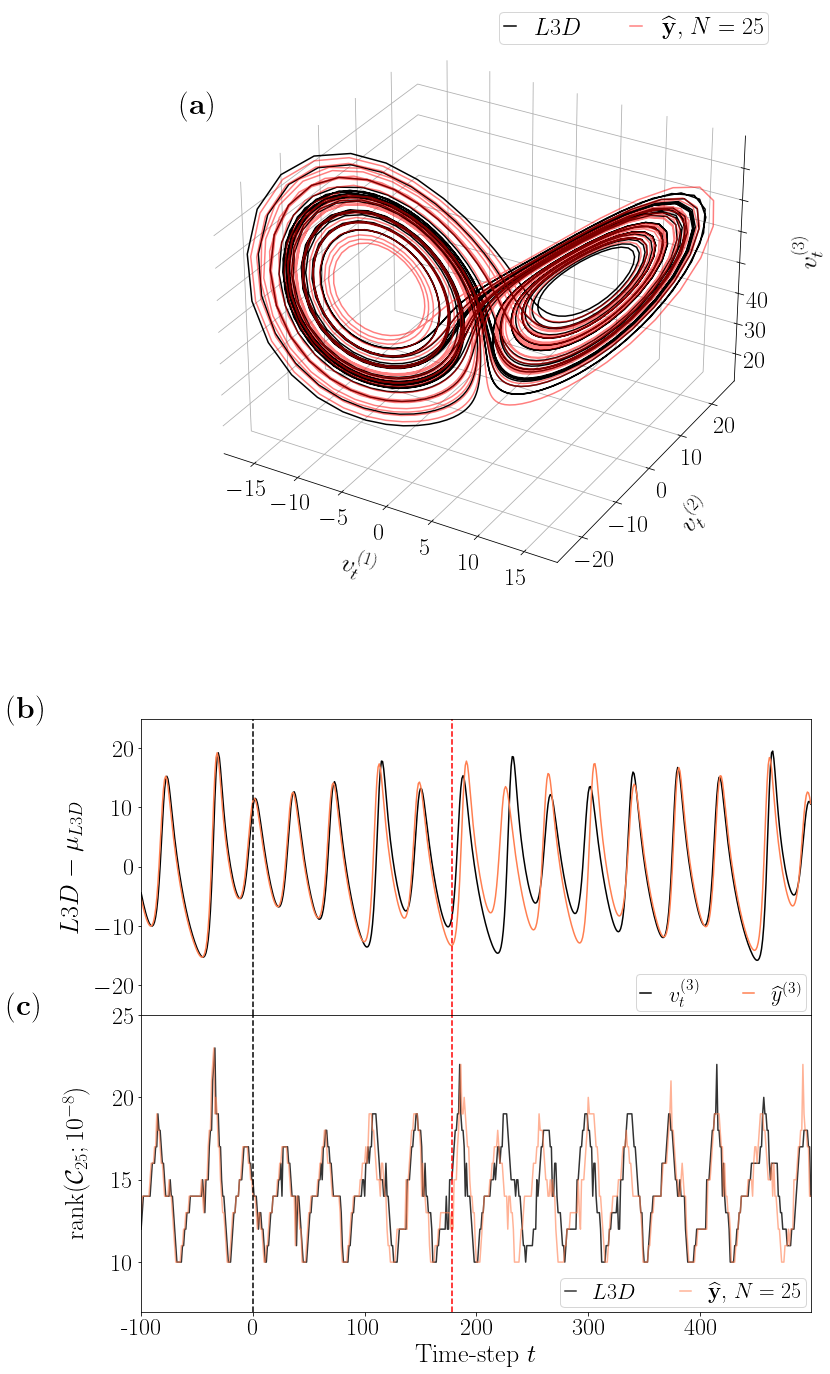

In [16]:
signal = np.load('Lxyz_signal.npy')
p3D25 = yhat #np.load(f'Consistent/L3D/L3D{N}/L3D_iter{it}_{N}_preds.npy')


gs = gridspec.GridSpec(2, 1)
fig = plt.figure(figsize=(12,24))
ax1 = fig.add_subplot(gs[0], projection='3d')
#ax1 = fig.gca(projection='3d')
ax1.plot(signal[14000:,0]+mu[0], signal[14000:,1]+mu[1], signal[14000:,2]+mu[2], c='k', label='$L3D$')
ax1.plot(p3D25[14000:,0]+mu[0], p3D25[14000:,1]+mu[1], p3D25[14000:,2]+mu[2], c='r', label='$\widehat{\mathbf{y}},$ $N=25$', alpha=.5)
ax1.set_xlabel('$v^{(1)}_t$', fontsize=26, color='black')
ax1.set_ylabel('$v^{(2)}_t$', fontsize=26, color='black')
ax1.set_zlabel('$v^{(3)}_t$', fontsize=26, color='black')
ax1.w_xaxis.set_pane_color ((0., 0., 0., 0.))
ax1.w_yaxis.set_pane_color ((0., 0., 0., 0.))
ax1.w_zaxis.set_pane_color ((0., 0., 0., 0.))
ax1.xaxis.labelpad = 20
ax1.yaxis.labelpad = 20
ax1.zaxis.labelpad = 20
ax1.set_zticklabels([10,20,30,40])
ax1.legend(fontsize=24,
           labelcolor='black',
           ncol=2,
           handlelength=.5,
           borderpad=.2,
           borderaxespad=.2)
ax1.text(-.2, 1.,310,s='$(\mathbf{a})$', transform=ax1.transAxes, 
            size=30, weight='bold')

gs1 = gs[1].subgridspec(2,1, hspace=0)
ax2 = plt.subplot(gs1[0])
ax2.text(-0.2, 1.,s='$(\mathbf{b})$', transform=ax2.transAxes, 
            size=30, weight='bold')
#ax2.plot(signal[top:bottom-500, 0], label='$v^{(1)}_t$')
#ax2.plot(signal[top:bottom-500, 1], label='$v^{(2)}_t$')
ax2.plot(signal[top:bottom-500, 2], color='k', label='$v^{(3)}_t$')
ax2.plot(yhat[top:bottom-500, 2],'coral', ms=3, label = '$\widehat{y}^{(3)}$')
ax2.axvline(100, color='k', linestyle='dashed')
ax2.axvline(278, color='r', linestyle='dashed')
ax2.set_ylabel('$L3D -\mu_{L3D}$', labelpad=10)
ax2.set_ylim(-25,25)
ax2.legend(loc='lower right',
           ncol=2 ,
           handlelength=.5,
           fontsize=22,
           borderpad=.2,
           borderaxespad=.2)
ax2.set_xticks([])

ax3 = plt.subplot(gs1[1])
#ax3.plot([x for x in range(top,bottom-500)],sig_rks30[:-500], width=1., color='k', label='$L3D$', alpha=.8)
#ax3.plot([x for x in range(top,bottom-500)],pred_rks30[:-500], width=1., color= 'coral', label='$\widehat{\mathbf{y}},$ $N=25$', alpha=.4)
ax3.plot([x for x in range(top,bottom-500)],sig_rks30[:-500], color='k', label='$L3D$', alpha=.8)
ax3.plot([x for x in range(top,bottom-500)],pred_rks30[:-500], color= 'coral', label='$\widehat{\mathbf{y}},$ $N=25$', alpha=.6)

ax3.set_ylabel('$\mathrm{rank}(\mathbf{\mathcal{C}}_{25};10^{-8})$', labelpad=22)
ax3.set_xlabel('Time-step $t$')
ax3.text(-0.2, 0,s='$(\mathbf{c})$', transform=ax2.transAxes, 
            size=30, weight='bold')
ax3.legend(handlelength=.5,
           ncol=2,
           loc='lower right',
           fontsize=22,
           borderpad=.2,
           borderaxespad=.2)
ax3.set_xticks([13900,14000,14100,14200,14300,14400])
ax3.set_xticklabels([-100,0,100,200,300,400])

maxradii = np.array(list(set((argrelmax(sigradius)[0]).tolist()) & set((np.where(sigradius>1)[0]).tolist())))


#ax2.vlines(maxradii[np.where(maxradii+13900<14500)[0]], -30,25, color='k', linewidths=1, ls='dotted')
#ax3.vlines(maxradii[np.where(maxradii+13900<14500)[0]]+13900, 5,25, color='k', linewidths=1, ls='dotted')
ax3.axvline(14000, color='k', linestyle='dashed')
ax3.axvline(14178, color='r', linestyle='dashed')
ax3.set_ylim(7,25)
plt.tight_layout()
plt.show()
fig.savefig("../ChaosPlots/L3D_lines_combined.pdf", format='pdf', bbox_inches='tight', pad_inches=.01)

In [ ]:

fig = plt.figure(figsize=(7,7))
ax1 = plt.axes( projection='3d')
#ax1 = fig.gca(projection='3d')
ax1.plot(signal[14000:,0]+mu[0], signal[14000:,1]+mu[1], signal[14000:,2]+mu[2], c='k', label='$L3D$')
ax1.plot(p3D25[14000:,0]+mu[0], p3D25[14000:,1]+mu[1], p3D25[14000:,2]+mu[2], c='r', label='$\widehat{\mathbf{y}},$ $N=25$', alpha=.5)
ax1.set_xlabel('$v^{(1)}_t$', fontsize=26, color='black')
ax1.set_ylabel('$v^{(2)}_t$', fontsize=26, color='black')
ax1.set_zlabel('$v^{(3)}_t$', fontsize=26, color='black')
ax1.w_xaxis.set_pane_color ((0., 0., 0., 0.))
ax1.w_yaxis.set_pane_color ((0., 0., 0., 0.))
ax1.w_zaxis.set_pane_color ((0., 0., 0., 0.))
ax1.xaxis.labelpad = 20
ax1.yaxis.labelpad = 20
ax1.zaxis.labelpad = 20
ax1.set_zticklabels([10,20,30,40])
ax1.legend(fontsize=24,
           labelcolor='black',
           ncol=2,
           handlelength=.5,
           borderpad=.2,
           borderaxespad=.2)

plt.show()
fig.savefig("../ChaosPlots/L3D_ppt.pdf", format='pdf', bbox_inches='tight', pad_inches=.01)

In [ ]:
maxradii[np.where(maxradii+13900<14500)[0]]

In [ ]:
def Rxy(x,y):
    return np.dot(x.T,y)/(np.linalg.norm(x)*np.linalg.norm(y))

In [ ]:
target = signal[:,0]
pred25 = yhat[:,0]
k_list = [5,10,20,25]
start, stop = 13000, 15500  #Depends on dataset should be last 1000 train to 500 of free-run
plt.figure(figsize=(15,5))
for k in k_list:
    trainCorr = np.zeros((stop-start)-k)
    for j in range(start, stop-k):
        tar = target[j:j+k].reshape((k,1))
        prd = pred25[j:j+k].reshape((k,1))
        trainCorr[j-start] = Rxy(tar,prd)
    minVal = trainCorr[:1000].min()
    threshold = minVal-(minVal*.05)
    thresholdLoc = np.where(trainCorr[1000:2000]<threshold)[0][0]
    print(f'k-size={k} Trainingset min={trainCorr[:1000].min().round(5)}  threshold={threshold:.5f}',
          f' Location={thresholdLoc}')
    plt.plot(trainCorr[:1500], label=f'k={k}')
    plt.axvline(1000+thresholdLoc,color='r')
plt.ylabel('$\mathbf{R}_{xy}$')
plt.xlabel('Time-steps $t$ samples are: Train $[0,1000]$, Test $[1000,1500]$')
plt.legend(fontsize=28)
plt.axvline(1000,color='k') #End trainset
plt.title('Divergence (red lines) by $\mathbf{R}_{xy}[k]$ for $k=5,10,20,25$')
plt.show()

In [ ]:
target = signal[:,1]
pred25 = yhat[:,1]
k_list = [5,10,20,25]
start, stop = 13000, 15500  #Depends on dataset should be last 1000 train to 500 of free-run
plt.figure(figsize=(15,5))
for k in k_list:
    trainCorr = np.zeros((stop-start)-k)
    for j in range(start, stop-k):
        tar = target[j:j+k].reshape((k,1))
        prd = pred25[j:j+k].reshape((k,1))
        trainCorr[j-start] = Rxy(tar,prd)
    minVal = trainCorr[:1000].min()
    threshold = minVal-(minVal*.05)
    thresholdLoc = np.where(trainCorr[1000:2000]<threshold)[0][0]
    print(f'k-size={k} Trainingset min={trainCorr[:1000].min().round(5)}  threshold={threshold:.5f}',
          f' Location={thresholdLoc}')
    plt.plot(trainCorr[:1500], label=f'k={k}')
    plt.axvline(1000+thresholdLoc,color='r')
plt.ylabel('$\mathbf{R}_{xy}$')
plt.xlabel('Time-steps $t$ samples are: Train $[0,1000]$, Test $[1000,1500]$')
plt.legend(fontsize=28)
plt.axvline(1000,color='k') #End trainset
plt.title('Divergence (red lines) by $\mathbf{R}_{xy}[k]$ for $k=5,10,20,25$')
plt.show()

In [ ]:
target = signal[:,2]
pred25 = yhat[:,2]
k_list = [5,10,20,25]
start, stop = 13000, 15500  #Depends on dataset should be last 1000 train to 500 of free-run
plt.figure(figsize=(15,5))
for k in k_list:
    trainCorr = np.zeros((stop-start)-k)
    for j in range(start, stop-k):
        tar = target[j:j+k].reshape((k,1))
        prd = pred25[j:j+k].reshape((k,1))
        trainCorr[j-start] = Rxy(tar,prd)
    minVal = trainCorr[:1000].min()
    threshold = 0.73534#minVal-(minVal*.05)
    thresholdLoc = np.where(trainCorr[1000:2000]<threshold)[0][0]
    print(f'k-size={k} Trainingset min={trainCorr[:1000].min().round(5)}  threshold={threshold:.5f}',
          f' Location={thresholdLoc}')
    plt.plot(trainCorr[:1500], label=f'k={k}')
    plt.axvline(1000+thresholdLoc,color='r')
plt.ylabel('$\mathbf{R}_{xy}$')
plt.xlabel('Time-steps $t$ samples are: Train $[0,1000]$, Test $[1000,1500]$')
plt.legend(fontsize=28)
plt.axvline(1000,color='k') #End trainset
plt.title('Divergence (red lines) by $\mathbf{R}_{xy}[k]$ for $k=5,10,20,25$')
plt.show()

In [ ]:
np.max(p3D25+mu,axis=0)

In [ ]:
np.min(p3D25+mu,axis=0)